# Keypoints Extraction


image 1/1 D:\Projects\FLASK\measuremates\evaluation\test dataset\example photo.jpg: 448x640 1 cow, 2005.0ms
Speed: 7.0ms preprocess, 2005.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


[]

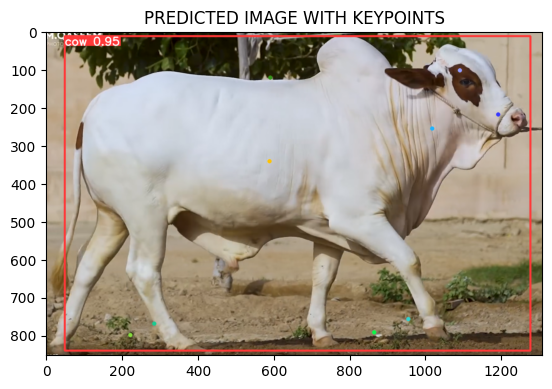

In [1]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

image_path='test dataset/example photo.jpg'

model=YOLO('../static/model/best_pose_model.pt')
results=model(source=image_path, conf=0.75, save=False)

predicted_image=results[0].plot()
rgb_predicted = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGBA)

plt.title('PREDICTED IMAGE WITH KEYPOINTS')
plt.imshow(rgb_predicted)
plt.plot()

We have 12 keypoints in a cow
    
    1.Nose
    2. Right Eye
    3. Left Eye
    4. Side Neck
    5. Left Front Hoof
    6. Right Front Hoof
    7. Left Back Hoof
    8. Right Back Hoof
    9. Backbone (side)
    10. Tail Root
    11. Back Pose Middle
    12. Center Point
    
 and all of these have some x,y,z coordinates in an image. 
 Note: If a part or keypoint is not visible then it's x,y,z coordinates will be 0.0 

In [2]:
predicted_keypoints=[]

kptss = results[0].keypoints.data
for kpts in kptss:
    for kpt in kpts:
        predicted_keypoints.append(kpt)


list_of_dicts = [{"x": kpt[0].item(), "y": kpt[1].item(), "z": kpt[2].item()} for kpt in predicted_keypoints]

for d in list_of_dicts:
    if d['x'] == 0.0 and d['y'] == 0.0:   # If x,y is 0 which means the object is not present in the photo therefore, z=0
        d['z'] = 0.0


In [3]:
list_of_dicts

[{'x': 1192.1397705078125, 'y': 219.2502899169922, 'z': 0.9008038640022278},
 {'x': 1091.7398681640625, 'y': 103.9752197265625, 'z': 0.9571262001991272},
 {'x': 0.0, 'y': 0.0, 'z': 0.0},
 {'x': 1018.2180786132812, 'y': 256.15545654296875, 'z': 0.982089638710022},
 {'x': 955.9326171875, 'y': 757.5151977539062, 'z': 0.8283687829971313},
 {'x': 865.4307861328125, 'y': 792.8687744140625, 'z': 0.9652423858642578},
 {'x': 285.70672607421875, 'y': 769.543212890625, 'z': 0.8199923038482666},
 {'x': 222.27149963378906, 'y': 799.5029296875, 'z': 0.9017370343208313},
 {'x': 591.5242309570312, 'y': 122.63095092773438, 'z': 0.7727588415145874},
 {'x': 0.0, 'y': 0.0, 'z': 0.0},
 {'x': 0.0, 'y': 0.0, 'z': 0.0},
 {'x': 589.1141357421875, 'y': 342.1628112792969, 'z': 0.9941633343696594}]

# detection+pose+height

In [15]:
import cv2
import json
import matplotlib.pyplot as plt
import logging

from ultralytics import YOLO

def model_implementation(image):
    try:
        image = cv2.imread(image)
        model = YOLO("../static/model/best_pose_model.pt")
        
        if model is None:
            return 'MODEL IS NOT LOADED', None, None
        
        results = model(source=image, save=False, conf=0.75, task='pose')
        
        predicted_data = json.loads(results[0].tojson())  #[{ list of dict }] + all of the output in json format to see what object is detected marked

        # Required Variables
        detected_object = None
        pose = None
        height = None
        
        """ Logic: We have 2 classes in our dataset which are 'cow' and 'other'. If there is no object detected or
            other object detected, means there's no cow present in the given image. Hence No keypoints, working
            will be triggered in this situation """
        
        count = 0
        
        for item in predicted_data:
            if item.get('name', '') == 'other' or item == []:
                detected_object = 'Other'
            
            elif item.get('name', '') == 'cow':
                detected_object = 'cow'
                count = count + 1
                object_count = f"{count} {detected_object} detected in the given image"

                # Predicted keypoints
                predicted_keypoints = []

                kptss = results[0].keypoints.data
                for kpts in kptss:
                    for kpt in kpts:
                        predicted_keypoints.append(kpt)

                list_of_dicts = [{"x": kpt[0].item(), "y": kpt[1].item(), "z": kpt[2].item()} for kpt in predicted_keypoints]

                for d in list_of_dicts:
                    if d['x'] == 0.0 and d['y'] == 0.0:   # If x,y is 0 which means the object is not present in the photo, therefore, z=0
                        d['z'] = 0.0

                # Pose detection working
                pose = ''

                if (list_of_dicts[1].get('x') == 0 and list_of_dicts[2].get('x') != 0) and list_of_dicts[10].get('x') == 0:
                    pose = 'left'

                elif (list_of_dicts[1].get('x') != 0 and list_of_dicts[2].get('x') == 0) and list_of_dicts[10].get('x') == 0:
                    pose = 'right'
                else:
                    print('Retake the photo')
                    pose = None

                # Height estimation working
                if pose == 'left':
                    first_foot = list_of_dicts[4]  # left front foot
                    second_foot = list_of_dicts[5]  # left back foot

                    height = ''

                    for h in [first_foot, second_foot]:
                        if (h.get('x') and h.get('y')) > 800:
                            height = 'normal'

                        elif (h.get('x') or h.get('y')) == 0:
                            height = 'Please retake the image as one of the hoof is not clearly visible'

                        else:
                            height = 'Not Normal'

                if pose == 'right':
                    first_foot = list_of_dicts[6]  # right front foot
                    second_foot = list_of_dicts[7]  # right back foot

                    for h in [first_foot, second_foot]:
                        if (h.get('x') and h.get('y')) > 800:
                            height = 'normal'

                        elif (h.get('x') or h.get('y')) == 0:
                            height = 'Please retake the image as one of the hoof is not clearly visible'

                        else:
                            height = 'Not Normal'

                # Plot the image
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                plt.imshow(image)
                plt.title('Uploaded Image')
                plt.imshow(image)
                plt.plot()

        return detected_object, pose, height
            
    except Exception as e:
        logging.exception("An error occurred: %s", str(e))
        return e  # Return None in case of error (silencer)

In [16]:
def predictions(image_path):
    detected_object, pose, height = model_implementation(image_path)
    
    if detected_object == 'cow':
        print(f'The pose of cow is: {pose}')
        print(f'The height of cow is: {height}')
    else:
        print('Cow is not detected in the given image')



In [17]:
image_path = 'test dataset/cat.jpg'
output = predictions(image_path)


0: 448x640 1 other, 895.6ms
Speed: 0.0ms preprocess, 895.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
Cow is not detected in the given image



0: 608x640 1 cow, 1224.6ms
Speed: 22.2ms preprocess, 1224.6ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)
The pose of cow is: right
The height of cow is: Not Normal


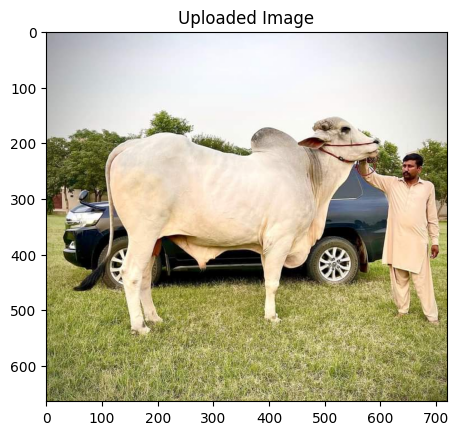

In [18]:
image_path = 'test dataset/cow2.jpg'
output = predictions(image_path)